#  Analiza zmian jeziora Aralskiego (2017–2025)
## Sentinel‑2 + Microsoft Planetary Computer + Apache Sedona

**Cel ćwiczenia:**
1) Pobierz dane Sentinel‑2 (Green – `B03`, NIR – `B08`) z Microsoft Planetary Computer dla jeziora Aralskiego — po 1 scenie na każdy rok 2017–2025 (preferencyjnie czerwiec–sierpień, zachmurzenie < 10%).
2) Wczytaj dane do Apache Sedona (Spark) i wykonaj analizę NDWI: `NDWI = (Green - NIR) / (Green + NIR)`.
3) Zwizualizuj zmiany średniego NDWI w czasie.



##  Środowisko i biblioteki
Zalecane biblioteki:
- `pystac-client`, `planetary_computer`, 

Zainstaluj, jeśli potrzeba (np. dla obrazu Dockera)

In [3]:
import datetime as dt
import os
import pystac_client
import planetary_computer
import stackstac
import rioxarray as rxr
import numpy as np
from sedona.spark import SedonaContext
import re
from pystac_client import Client
import planetary_computer as pc
import requests
import os
from pystac_client import Client
from planetary_computer import sign as pc_sign
import os, requests


## 1) Pobranie danych z Microsoft Planetary Computer
Napisz funkcję `get_aral_s2(years, bbox)`, która dla każdego roku zwróci po 1 najlepszej scenie Sentinel‑2 L2A (najmniejsze zachmurzenie w czerwcu–sierpniu).

**Wskazówki:**
- Katalog STAC: `https://planetarycomputer.microsoft.com/api/stac/v1`
- Kolekcja: `sentinel-2-l2a`
- Filtrowanie: `datetime`, `bbox`, `eo:cloud_cover < 20`, preferuj letnie miesiące.
- Użyj `planetary_computer.sign()` do podpisywania assets.
- Do wczytania pasm użyj `stackstac.stack()`.

In [16]:

mgrs_tile = "40TGS"          
start_year = 2017
end_year = 2025
output_dir = "/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data"

os.makedirs(output_dir, exist_ok=True)

# Połączenie z Planetary Computer STAC 
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Pętla po latach
for year in range(start_year, end_year + 1):
    # tylko miesiące czerwiec–sierpień
    start = f"{year}-06-01"
    end = f"{year}-08-31"
    print(f"\nSzukam sceny dla roku {year} ({start} → {end})...")

    # Szukamy scen Sentinel-2 L2A dla danego kafelka i roku
    search = stac.search(
        collections=["sentinel-2-l2a"],
        query={
            "s2:mgrs_tile": {"eq": mgrs_tile},
            "eo:cloud_cover": {"lt": 50}
        },
        datetime=f"{start}/{end}",
        sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
        limit=1  # tylko najlepsza (najmniej zachmurzona)
    )

    items = list(search.items())
    if not items:
        print(f"Brak scen dla {year}.")
        continue

    item = items[0]
    cloud = item.properties.get("eo:cloud_cover", "?")
    date = item.properties["datetime"]
    print(f"Wybrano: {item.id} (data: {date}, zachmurzenie: {cloud}%)")

    # Pobierz assety B03 i B08
    for band in ["B03", "B08"]:
        asset = item.assets.get(band)
        if not asset:
            print(f"Brak pasma {band} w {item.id}")
            continue

        signed_href = pc_sign(asset.href)
        out_path = os.path.join(output_dir, f"{year}_{band}_{mgrs_tile}.tif")

        if os.path.exists(out_path):
            print(f"Już istnieje: {out_path}")
            continue

        print(f"Pobieram {band} do {out_path} ...")
        with requests.get(signed_href, stream=True) as r:
            r.raise_for_status()
            with open(out_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    f.write(chunk)
        print(f"Zapisano: {out_path}")



Szukam sceny dla roku 2017 (2017-06-01 → 2017-08-31)...
Wybrano: S2B_MSIL2A_20170820T065619_R063_T40TGS_20201015T042054 (data: 2017-08-20T06:56:19.027000Z, zachmurzenie: 0.515466%)
Pobieram B03 do /home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/2017_B03_40TGS.tif ...
Zapisano: /home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/2017_B03_40TGS.tif
Pobieram B08 do /home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/2017_B08_40TGS.tif ...
Zapisano: /home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/2017_B08_40TGS.tif

Szukam sceny dla roku 2018 (2018-06-01 → 2018-08-31)...
Wybrano: S2B_MSIL2A_20180828T070609_R106_T40TGS_20201027T060223 (data: 2018-08-28T07:06:09.024000Z, zachmurzenie: 0.0%)
Pobieram B03 do /home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/2018_B03_40TGS.tif ...
Zapisano: /home/scoora/studies/automated_workflows/autom

## 2) Wczytanie do Apache Sedona i przygotowanie danych NDWI
Utwórz sesję Spark + Sedona. Następnie załaduj raster

In [4]:
config = (
    SedonaContext.builder()
    .config(
        "spark.jars.packages",
        ",".join([
            "org.apache.sedona:sedona-spark-shaded-4.0_2.13:1.8.0",
            "org.datasyslab:geotools-wrapper:1.8.0-33.1",
            "org.apache.hadoop:hadoop-aws:3.3.2"
        ])
    )
    .config("spark.jars.repositories", "https://artifacts.unidata.ucar.edu/repository/unidata-all")        
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "true") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
        "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .config("spark.executor.memory", "6G")
    .config("spark.driver.memory", "6G")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)
 
sedona = SedonaContext.create(config)
sedona.sparkContext.setLogLevel("ERROR")
 
sedona.conf.set("fs.https.impl", "org.apache.hadoop.fs.http.HttpsFileSystem")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/01 18:43:11 WARN Utils: Your hostname, masina-skurki, resolves to a loopback address: 127.0.1.1; using 192.168.1.45 instead (on interface enx207bd255e416)
25/11/01 18:43:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://artifacts.unidata.ucar.edu/repository/unidata-all added as a remote repository with the name: repo-1
:: loading settings :: url = jar:file:/home/scoora/studies/automated_workflows/automated_workflows_lab/apache_env/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/scoora/.ivy2.5.2/cache
The jars for the packages stored in: /home/scoora/.ivy2.5.2/jars
org.apache.sedona#sedona-spark-shaded-4.0_2.13 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark

## 3) Obliczenie NDWI
Uzyj wzoru `ndwi = (green - nir) / (green + nir)` i policz średni NDWI dla każdego roku.

In [ ]:
import os
import numpy as np
import rasterio
from pyspark.sql import Row

folder = "/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data"
output_dir = "/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi"
os.makedirs(output_dir, exist_ok=True)

b03_files = sorted([f for f in os.listdir(folder) if "_B03_" in f])
b08_files = sorted([f for f in os.listdir(folder) if "_B08_" in f])

pairs = []
for b03 in b03_files:
    year = b03.split("_")[0]
    match = [f for f in b08_files if year in f]
    if match:
        pairs.append((year, os.path.join(folder, b03), os.path.join(folder, match[0])))

print(f"Znaleziono {len(pairs)} par plików")

def compute_ndwi(year, b03_path, b08_path):
    with rasterio.open(b03_path) as b3, rasterio.open(b08_path) as b8:
        green = b3.read(1).astype("float32")
        nir = b8.read(1).astype("float32")
        ndwi = np.where((green + nir) != 0, (green - nir) / (green + nir), 0)
        profile = b3.profile
        profile.update(dtype=rasterio.float32, count=1)
        out_path = os.path.join(output_dir, f"{year}_NDWI.tif")
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(ndwi, 1)
        return Row(year=year, path=out_path)

# rownolegle w Spark
rdd = sedona.sparkContext.parallelize(pairs, numSlices=2)
results = rdd.map(lambda p: compute_ndwi(*p)).collect()

print("Zapisano NDWI:")
for r in results:
    print(r)


Znaleziono 9 par plików


/tmp/ipykernel_13979/3918498691.py:26: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_13979/3918498691.py:26: RuntimeWarning: invalid value encountered in divide


Zapisano NDWI:
Row(year='2017', path='/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi/2017_NDWI.tif')
Row(year='2018', path='/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi/2018_NDWI.tif')
Row(year='2019', path='/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi/2019_NDWI.tif')
Row(year='2020', path='/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi/2020_NDWI.tif')
Row(year='2021', path='/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi/2021_NDWI.tif')
Row(year='2022', path='/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi/2022_NDWI.tif')
Row(year='2023', path='/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi/2023_NDWI.tif')
Row(year='2024', path='/home/scoora/stud

In [5]:
from pyspark.sql import Row
import pandas as pd
import os
import rasterio
import numpy as np

folder = "/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi"
ndwi_files = sorted([f for f in os.listdir(folder) if f.endswith("_NDWI.tif")])

def mean_ndwi(file):
    year = os.path.basename(file).split("_")[0]
    with rasterio.open(file) as src:
        data = src.read(1, masked=True)
        mean = float(np.nanmean(data))
    # zwracamy słownik, nie Row — pandas sobie poradzi
    return {"year": int(year), "mean_ndwi": mean}

rdd = sedona.sparkContext.parallelize([os.path.join(folder, f) for f in ndwi_files])
results = rdd.map(mean_ndwi).collect()
df = pd.DataFrame(results)
df = df.sort_values("year")

print("\nŚrednie NDWI:")
print(df)



Średnie NDWI:
   year     mean_ndwi
0  2017  1.572625e-02
1  2018 -9.556435e-06
2  2019  4.045601e-03
3  2020 -1.962876e-06
4  2021 -2.648227e-07
5  2022 -5.360596e-02
6  2023 -3.184683e-02
7  2024 -2.576635e-02
8  2025 -3.563085e-02


## 4) Wykres zmian NDWI (2017–2025)
Utwórz wykres liniowy średniego NDWI.

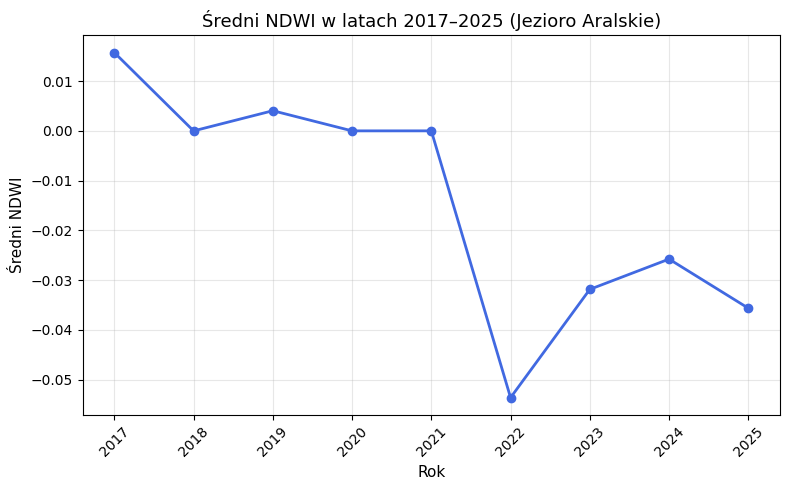

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df["year"], df["mean_ndwi"], marker="o", linestyle="-", color="royalblue", linewidth=2)
plt.title("Średni NDWI w latach 2017-2025 (Jezioro Aralskie)", fontsize=13)
plt.xlabel("Rok", fontsize=11)
plt.ylabel("Średni NDWI", fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(df["year"], rotation=45)
plt.tight_layout()
plt.show()


## 5) Wizualizacja wyników - wszystkie lata


/tmp/ipykernel_23727/2619167180.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


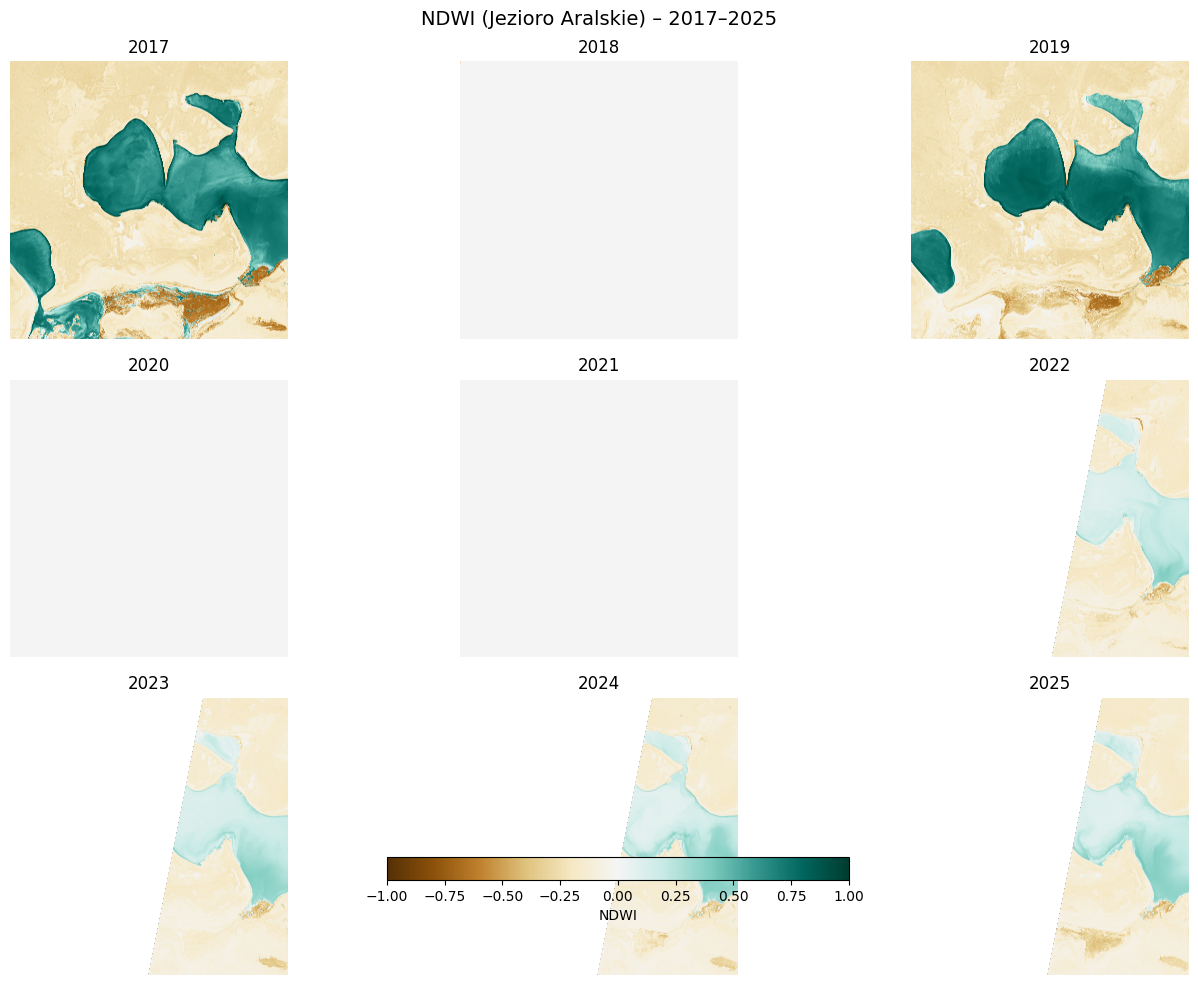

In [ ]:
#import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

folder = "/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi"
ndwi_files = sorted([f for f in os.listdir(folder) if f.endswith("_NDWI.tif")])

# Ustal rozmiar siatki (np. 3x3 dla 9 lat)
cols = 3
rows = int(np.ceil(len(ndwi_files) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, f in enumerate(ndwi_files):
    path = os.path.join(folder, f)
    year = f.split("_")[0]
    with rasterio.open(path) as src:
        ndwi = src.read(1, masked=True)
        img = axes[i].imshow(ndwi, cmap="BrBG", vmin=-1, vmax=1)
        axes[i].set_title(year)
        axes[i].axis("off")

# Legenda
fig.colorbar(img, ax=axes, orientation="horizontal", fraction=0.03, pad=0.05, label="NDWI")
plt.suptitle("NDWI (Jezioro Aralskie) - 2017-2025", fontsize=14)
plt.tight_layout()
plt.show()


In [8]:
import rasterio
import os

folder = "/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi"
ndwi_files = sorted([f for f in os.listdir(folder) if f.endswith("_NDWI.tif")])

for f in ndwi_files:
    with rasterio.open(os.path.join(folder, f)) as src:
        print(f"{f}: {src.crs}, {src.bounds}")


2017_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2018_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2019_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2020_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2021_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2022_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2023_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2024_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)
2025_NDWI.tif: EPSG:32640, BoundingBox(left=699960.0, bottom=5090220.0, right=809760.0, top=5200020.0)


In [9]:
import numpy as np
import rasterio
import os

older = "/home/scoora/studies/automated_workflows/automated_workflows_lab/lab_02/band_data/sentinel_ndwi"
ndwi_files = sorted([f for f in os.listdir(folder) if f.endswith("_NDWI.tif")])

for f in ndwi_files:
    path = os.path.join(folder, f)
    with rasterio.open(path) as src:
        data = src.read(1, masked=True)
        valid = np.sum(~data.mask)
        mean = np.nanmean(data)
        print(f"{f}: valid pixels={valid}, mean={mean:.4f}")


2017_NDWI.tif: valid pixels=1, mean=0.0157
2018_NDWI.tif: valid pixels=1, mean=-0.0000
2019_NDWI.tif: valid pixels=1, mean=0.0040
2020_NDWI.tif: valid pixels=1, mean=-0.0000
2021_NDWI.tif: valid pixels=1, mean=-0.0000
2022_NDWI.tif: valid pixels=47623908, mean=-0.0536
2023_NDWI.tif: valid pixels=48650054, mean=-0.0318
2024_NDWI.tif: valid pixels=49078099, mean=-0.0258
2025_NDWI.tif: valid pixels=49505962, mean=-0.0356
